# vaxxAId

**VaxxAId** aims to cluster and find similarities among patients who experienced COVID-19 vaccine adverse reactions or side effects based on the reports from the Vaccine Adverse Event Reporting System (VAERS). This would aid in the identification and classification of patients at risk of such effects. It will use the **K-modes clustering algorithm** to cluster the reports based on features such as patient outcomes, demographics, type of vaccine received, etc.

This project is developed by:
- Rene Lee Aquitania
- Alyssa Beatrice Diokno
- Derryn Joi Martirez
- Marie Isabel Yao

## PART 1: Data Preprocessing

### PART 1.1: Importing the Libraries

Before running the code below, make sure to install the following libraries using `conda install <package-name>`: 
- `pandas`
- `numpy`
- `matplotlib`
- `seaborn`
- `sklearn`

Install the following libraries as well using `pip install <package-name>`:
- `kmodes`
- `kneed`

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
# import ipynb.fs.defs.utils as utils

from kmodes.kmodes import KModes
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from kneed import KneeLocator

### PART 1.2: Data Cleaning

We start by reading the following CSV files into separate dataframes. For each year, we have patient data and vaccine data from two dataframes that can be joined on the key `VAERS_ID`.

In [2]:
patients2021 = pd.read_csv('../data/2021VAERSDATA.csv', encoding='latin1')
vaccine2021 = pd.read_csv('../data/2021VAERSVAX.csv', encoding='latin1')

patients2022 = pd.read_csv('../data/2022VAERSDATA.csv', encoding='latin1')
vaccine2022 = pd.read_csv('../data/2022VAERSVAX.csv', encoding='latin1')

# Joining the dataframes on VAERS_ID
patients2021 = patients2021.join(vaccine2021.set_index('VAERS_ID'), on='VAERS_ID', how='inner')
patients2022 = patients2022.join(vaccine2022.set_index('VAERS_ID'), on='VAERS_ID', how='inner')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10388\2851924540.py:1: DtypeWarning: Columns (7,12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  patients2021 = pd.read_csv('../data/2021VAERSDATA.csv', encoding='latin1')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10388\2851924540.py:4: DtypeWarning: Columns (7,12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  patients2022 = pd.read_csv('../data/2022VAERSDATA.csv', encoding='latin1')


Since the datasets may contain reports on adverse effects of other FDA-approved vaccines, we only keep rows where the vaccine type is COVID-19. Finally, we concatenate the 2021 and 2022 dataframes.

In [3]:
patients2021 = patients2021[patients2021['VAX_TYPE']=='COVID19']
patients2022 = patients2022[patients2022['VAX_TYPE']=='COVID19']

patients = pd.concat([patients2021, patients2022], axis=0)

features = [
    'VAERS_ID','AGE_YRS','SEX','DIED','L_THREAT',
    'ER_VISIT','HOSPITAL','DISABLE','BIRTH_DEFECT','RECOVD',
    'V_ADMINBY','VAX_TYPE','VAX_MANU','VAX_SITE','VAX_ROUTE'
    ]
    
patients = patients[features]

patients = patients.drop(['VAX_TYPE'],axis=1)

patients.to_csv('../data/20212022DATA.csv', index=False)

patients_df = pd.read_csv('../data/20212022DATA.csv', encoding='latin1')

patients

,VAERS_ID,AGE_YRS,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,RECOVD,V_ADMINBY,VAX_MANU,VAX_SITE,VAX_ROUTE
0,916600,33.0,F,NaN,NaN,NaN,NaN,NaN,NaN,Y,PVT,MODERNA,LA,IM
1,916601,73.0,F,NaN,NaN,NaN,NaN,NaN,NaN,Y,SEN,MODERNA,RA,IM
2,916602,23.0,F,NaN,NaN,NaN,NaN,NaN,NaN,U,SEN,PFIZER\BIONTECH,LA,IM
3,916603,58.0,F,NaN,NaN,NaN,NaN,NaN,NaN,Y,WRK,MODERNA,NaN,NaN
4,916604,47.0,F,NaN,NaN,NaN,NaN,NaN,NaN,N,PUB,MODERNA,LA,IM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115774,2265774,27.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UNK,PFIZER\BIONTECH,RA,IM
115775,2265775,73.0,M,NaN,NaN,NaN,Y,NaN,NaN,N,PHM,MODERNA,RA,IM
115776,2265776,23.0,F,NaN,NaN,NaN,NaN,NaN,NaN,Y,PHM,PFIZER\BIONTECH,LA,IM
115777,2265777,50.0,M,NaN,NaN,NaN,NaN,NaN,NaN,Y,PHM,PFIZER\BIONTECH,LA,IM


Described in the following table are the attributes for the clustering process. All of these are categorical data.

| Attributes | Data Type | Description |
| ---------- | --------- | ----------- |
| `AGE_GRP`      | range     | Age group                                                   |
| `SEX`          | char(1)   | Sex                                                         |
| `DIED`         | char(1)   | Adverse effect caused death of the patient                  |
| `L_THREAT`     | char(1)   | Life-threatening event associated with the vaccination      |
| `ER_VISIT`     | char(1)   | Patient required ER visit after experiencing adverse effect |
| `HOSPITAL`     | char(1)   | Patient was hospitalized after experiencing adverse effect  |
| `DISABLE`      | char(1)   | Patient was disabled after experiencing adverse effect      |
| `BIRTH_DEFECT` | char(1)   | Patient has birth defect                                    |
| `RECOVD`       | char(1)   | Patient recovered from adverse effect                       |
| `V_ADMINBY`    | char(3)   | Vaccine administered at                                     |
| `VAX_MANU`     | char(40)  | Vaccine manufacterer                                        |
| `VAX_SITE`     | char(6)   | Vaccination anatomic site                                   |
| `VAX_ROUTE`    | char(6)   | Vaccine route of administration                             |

The following function further cleans the data in the specified columns as some null values are equal to `"N"` (for the yes or no attributes):
- `AGE_GRP`: maps `AGE_YRS` into an age group
- `DIED`: replaces null values with `N`
- `L_THREAT`: replaces null values with `N`
- `ER_VISIT`: replaces null values with `N`
- `HOSPITAL`: replaces null values with `N`
- `DISABLE`: replaces null values with `N`
- `BIRTH_DEFECT`: replaces null values with `N`

After passing the dataframe into the `replace_values` function, the only null values left in the dataframe are actual null values which we can drop.

In [4]:
def replace_values(df):
    # Add a new column, AGE_GRP, and drop AGE_YRS
    age_max = df['AGE_YRS'].max()
    multiplier = 10 ** -1
    agegrp_max = int(math.ceil(age_max * multiplier) / multiplier)
    age_grp = [i for i in range(0,agegrp_max+1,10)]
    df['AGE_GRP'] = pd.cut(x=df['AGE_YRS'], bins=age_grp).astype(str)
    df = df.drop(['AGE_YRS'],axis=1)

    # Fill na with the following corresponding values
    values = {'DIED': 'N', 'L_THREAT': 'N', 'ER_VISIT': 'N', 'HOSPITAL':'N', 'DISABLE':'N', 'BIRTH_DEFECT':'N'}
    df = df.fillna(value=values)
    
    return df

patients = replace_values(patients)
patients

,VAERS_ID,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,RECOVD,V_ADMINBY,VAX_MANU,VAX_SITE,VAX_ROUTE,AGE_GRP
0,916600,F,N,N,N,N,N,N,Y,PVT,MODERNA,LA,IM,"(30, 40]"
1,916601,F,N,N,N,N,N,N,Y,SEN,MODERNA,RA,IM,"(70, 80]"
2,916602,F,N,N,N,N,N,N,U,SEN,PFIZER\BIONTECH,LA,IM,"(20, 30]"
3,916603,F,N,N,N,N,N,N,Y,WRK,MODERNA,NaN,NaN,"(50, 60]"
4,916604,F,N,N,N,N,N,N,N,PUB,MODERNA,LA,IM,"(40, 50]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115774,2265774,F,N,N,N,N,N,N,NaN,UNK,PFIZER\BIONTECH,RA,IM,"(20, 30]"
115775,2265775,M,N,N,N,Y,N,N,N,PHM,MODERNA,RA,IM,"(70, 80]"
115776,2265776,F,N,N,N,N,N,N,Y,PHM,PFIZER\BIONTECH,LA,IM,"(20, 30]"
115777,2265777,M,N,N,N,N,N,N,Y,PHM,PFIZER\BIONTECH,LA,IM,"(40, 50]"


In [5]:
# Checking the number of null values

patients.replace(["U","UN","UNK","UNKNOWN MANUFACTURER","nan"], np.nan, inplace=True)
patients.isna().sum()

VAERS_ID            0
SEX              7178
DIED                0
L_THREAT            0
ER_VISIT            0
HOSPITAL            0
DISABLE             0
BIRTH_DEFECT        0
RECOVD          62481
V_ADMINBY       50454
VAX_MANU          484
VAX_SITE        56389
VAX_ROUTE       45379
AGE_GRP         16883
dtype: int64

In the succeeding code blocks, we drop the rows with null values. We also replace `"U"`, `"UNK"` and `"UNKNOWN MANUFACTURER"` values in the dataframe with `np.nan` for easy dropping.

In [6]:
patients.dropna(inplace=True)
patients.isna().sum()

VAERS_ID        0
SEX             0
DIED            0
L_THREAT        0
ER_VISIT        0
HOSPITAL        0
DISABLE         0
BIRTH_DEFECT    0
RECOVD          0
V_ADMINBY       0
VAX_MANU        0
VAX_SITE        0
VAX_ROUTE       0
AGE_GRP         0
dtype: int64

In [7]:
# Remove rows where AGE_GRP is unknown

print(patients.AGE_GRP.value_counts())
print("\n")
print(patients.SEX.value_counts())
print("\n")
print(patients.RECOVD.value_counts())

(50, 60]      9007
(40, 50]      8708
(30, 40]      8601
(60, 70]      7681
(20, 30]      5244
(70, 80]      4326
(10, 20]      3077
(80, 90]      1611
(0, 10]       1258
(90, 100]      409
(100, 110]      26
Name: AGE_GRP, dtype: int64


F    34944
M    15004
Name: SEX, dtype: int64


N    26767
Y    23181
Name: RECOVD, dtype: int64


In [8]:
print(patients.V_ADMINBY.value_counts())
print("\n")
print(patients.VAX_MANU.value_counts())

PVT    18093
PHM    14526
OTH     6289
PUB     5467
WRK     2747
SEN     1287
MIL      866
SCH      673
Name: V_ADMINBY, dtype: int64


PFIZER\BIONTECH    24101
MODERNA            23619
JANSSEN             2228
Name: VAX_MANU, dtype: int64


In [9]:
print(patients.VAX_SITE.value_counts())
print("\n")
print(patients.VAX_ROUTE.value_counts())

LA    34682
RA    13007
AR     2033
OT      121
LL       53
RL       43
LG        6
GM        3
Name: VAX_SITE, dtype: int64


IM     34142
SYR    14015
OT      1441
SC       286
ID        54
JET       10
Name: VAX_ROUTE, dtype: int64


In [10]:
# We can select the first 30000 rows only.

patients.drop('VAERS_ID', inplace=True, axis=1)

### PART 1.3: Data Transformation

We now map nominal features into numerical labels for 

In [11]:
categorical = ['SEX','V_ADMINBY','VAX_MANU','VAX_SITE','VAX_ROUTE']

le = LabelEncoder()

for i in categorical:
    patients[i] = le.fit_transform(patients[i])


In [12]:
age_groups = {
    '(0, 10]': 0,
    '(10, 20]': 1,
    '(20, 30]': 2,
    '(30, 40]': 3,
    '(40, 50]': 4,
    '(50, 60]': 5,
    '(60, 70]': 6,
    '(70, 80]': 7,
    '(80, 90]': 8,
    '(90, 100]': 9,
    '(100, 110]': 10
}

patients.replace({'AGE_GRP': age_groups}, inplace=True)

In [13]:
binary = ['DIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'DISABLE', 'BIRTH_DEFECT', 'RECOVD']

for i in binary:
    patients[i] = patients[i].apply(lambda x: 1 if x=="Y" else 0)

patients.head()

,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,RECOVD,V_ADMINBY,VAX_MANU,VAX_SITE,VAX_ROUTE,AGE_GRP
0,0,0,0,0,0,0,0,1,4,1,2,1,3
1,0,0,0,0,0,0,0,1,6,1,6,1,7
4,0,0,0,0,0,0,0,0,3,1,2,1,4
5,0,0,0,0,0,0,0,1,4,1,2,1,4
6,1,0,0,0,0,0,0,1,3,1,2,1,4


In [28]:
columns = [
    'SEX', 'DIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'DISABLE', 'BIRTH_DEFECT',
    'RECOVD', 'V_ADMINBY', 'VAX_MANU', 'VAX_SITE', 'VAX_ROUTE', 'AGE_GRP'
    ]

# sample = patients.groupby(columns).filter(lambda x: len(x) > 20)
sample = patients.head(10000)
# sample.to_csv('../data/finaldataset.csv', index=False)
sample


,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,RECOVD,V_ADMINBY,VAX_MANU,VAX_SITE,VAX_ROUTE,AGE_GRP
0,0,0,0,0,0,0,0,1,4,1,2,1,3
1,0,0,0,0,0,0,0,1,6,1,6,1,7
4,0,0,0,0,0,0,0,0,3,1,2,1,4
5,0,0,0,0,0,0,0,1,4,1,2,1,4
6,1,0,0,0,0,0,0,1,3,1,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17405,0,0,0,0,0,0,0,1,4,1,2,1,6
17407,1,0,0,0,0,0,0,0,4,1,2,5,7
17408,0,0,0,0,0,0,0,1,6,2,2,1,9
17409,0,0,0,0,0,0,0,1,4,2,2,1,3


In [29]:
sample.value_counts()

SEX  DIED  L_THREAT  ER_VISIT  HOSPITAL  DISABLE  BIRTH_DEFECT  RECOVD  V_ADMINBY  VAX_MANU  VAX_SITE  VAX_ROUTE  AGE_GRP
0    0     0         0         0         0        0             0       4          1         2         1          3          188
                                                                1       4          2         2         1          3          180
                                                                                   1         2         1          3          169
                                                                                   2         2         1          4          164
                                                                0       4          1         2         1          4          152
                                                                                                                            ... 
                                                                1       6          1         2         1

## PART 2: Exploratory Data Analysis

### PART 2.1: Univariate Analysis

bar charts for one feature

### PART 2.2: Bivariate Analysis

stacked bar charts for two features

## PART 3: Model Implementation

### PART 3.1: Optimization of number of clusters

We used the **Elbow Method** to determine the optimal number of clusters into which the data might be clustered. We select the value of `k` at the "elbow" or the point after which the distortion/inertia starts decreasing in a linear fashion.

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1475, cost: 23936.0
Run 1, iteration: 2/100, moves: 616, cost: 23936.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1926, cost: 22980.0
Run 1, iteration: 2/100, moves: 319, cost: 22980.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2116, cost: 21739.0
Run 1, iteration: 2/100, moves: 300, cost: 21739.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2512, cost: 20270.0
Run 1, iteration: 2/100, moves: 1323, cost: 20270.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2188, cost: 20142.0
Run 1, iteration: 2/100, moves: 707, cost: 20142.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 

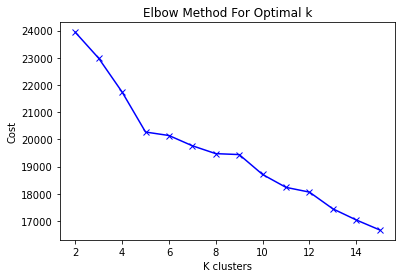

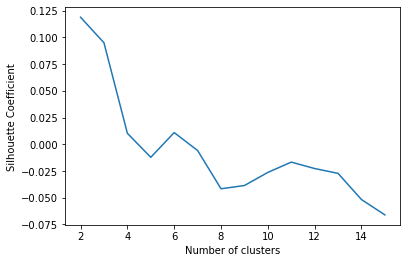

In [30]:
cost = []
scores = []
K = range(2,16)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(sample)
    cost.append(kmode.cost_)

    scores.append(metrics.silhouette_score(sample,kmode.labels_))
    
plt.plot(K, cost, 'bx-')
plt.xlabel('K clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

plt.plot(K,scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

Using the `KneeLocator` method from the `kneed` library, we identified the optimal number of clusters: $k=7$.

In [31]:
optimal_k = KneeLocator(list(K), cost, curve='convex', direction='decreasing')

k = optimal_k.knee

k

5

### PART 3.2: K-Modes Clustering

We now proceed to fitting the model to the `patients` dataframe, setting the number of clusters to `n_clusters = 7` and using the Cao initialization for categorical data clustering. We then put the generated labels or cluster numbers in a new column `CLUSTER`.

In [32]:
kmode = KModes(n_clusters=k, init = "Cao", n_init = 1, verbose=1)
labels = kmode.fit_predict(sample)
sample['CLUSTER'] = labels

sample

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2512, cost: 20270.0
Run 1, iteration: 2/100, moves: 1323, cost: 20270.0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10388\3963676046.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['CLUSTER'] = labels


,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,RECOVD,V_ADMINBY,VAX_MANU,VAX_SITE,VAX_ROUTE,AGE_GRP,CLUSTER
0,0,0,0,0,0,0,0,1,4,1,2,1,3,0
1,0,0,0,0,0,0,0,1,6,1,6,1,7,0
4,0,0,0,0,0,0,0,0,3,1,2,1,4,3
5,0,0,0,0,0,0,0,1,4,1,2,1,4,0
6,1,0,0,0,0,0,0,1,3,1,2,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17405,0,0,0,0,0,0,0,1,4,1,2,1,6,0
17407,1,0,0,0,0,0,0,0,4,1,2,5,7,4
17408,0,0,0,0,0,0,0,1,6,2,2,1,9,0
17409,0,0,0,0,0,0,0,1,4,2,2,1,3,0


## PART 4: Results and Discussion

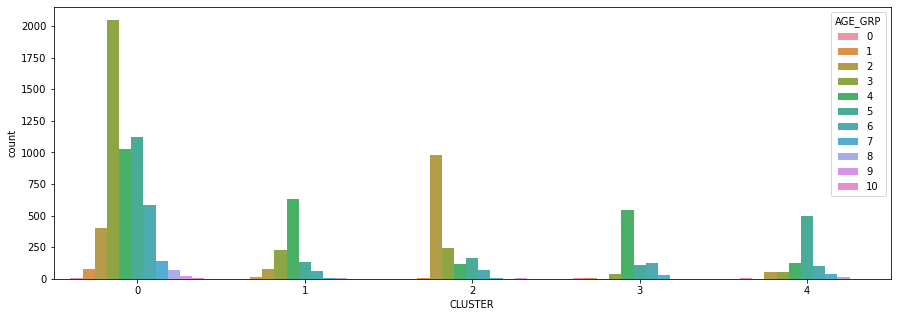

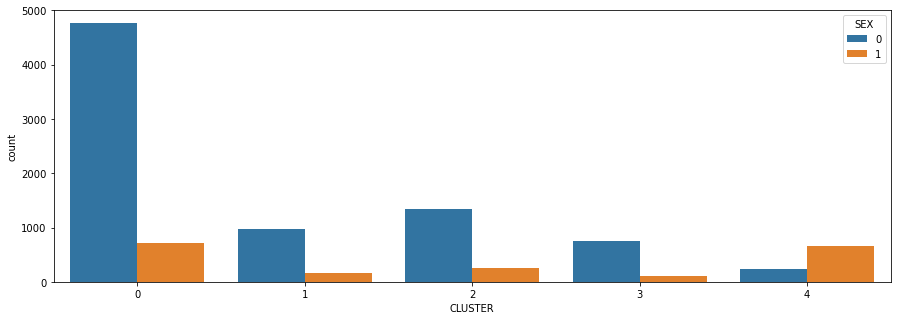

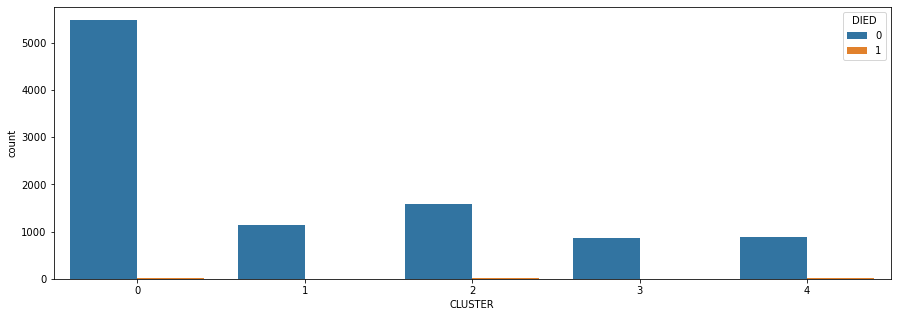

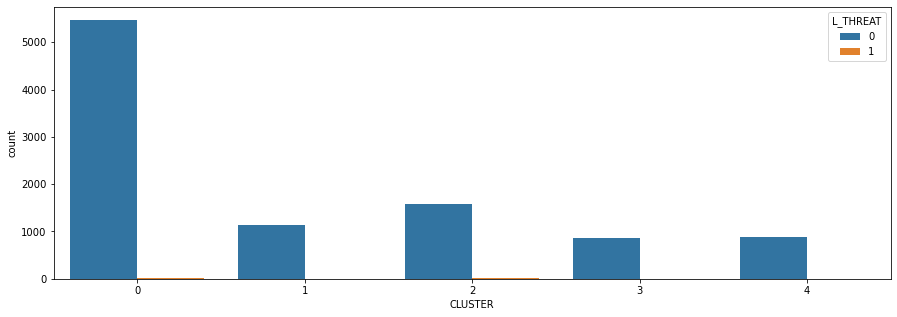

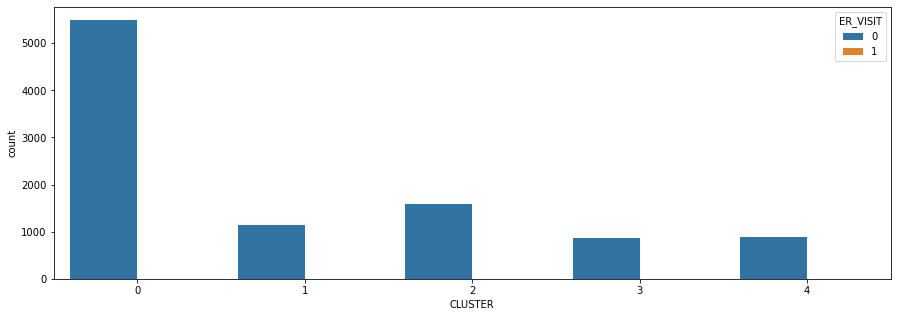

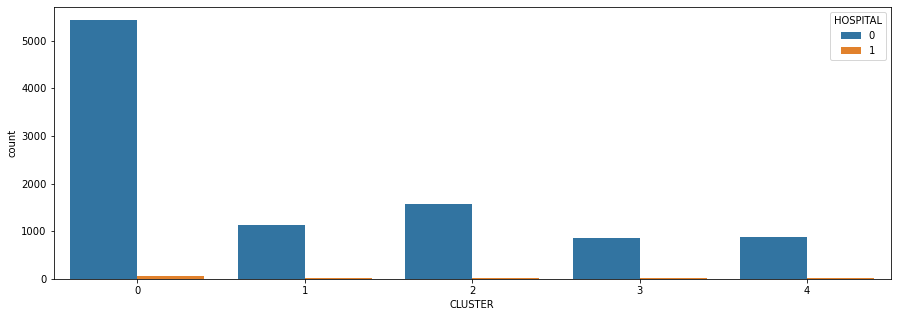

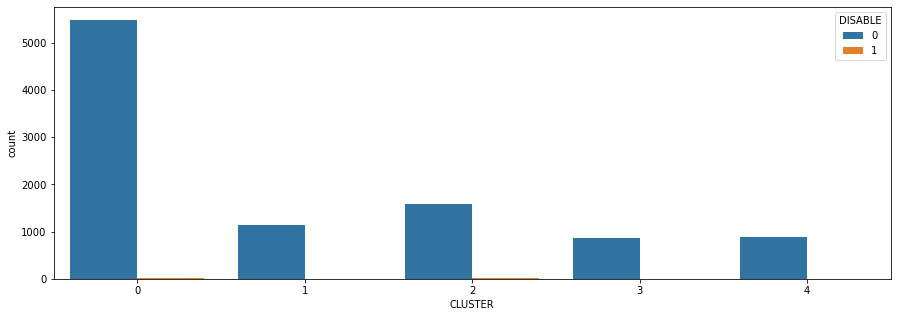

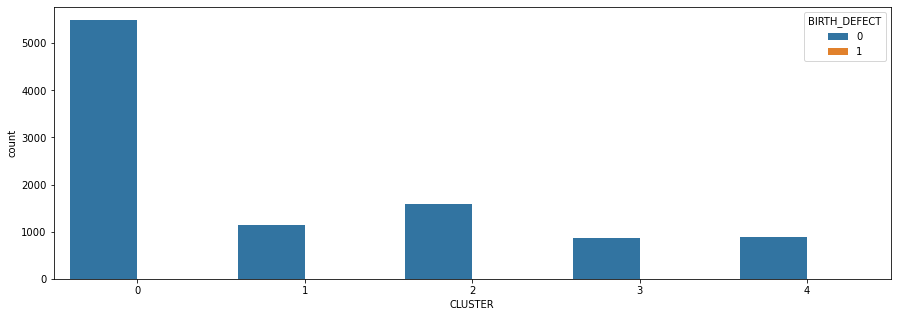

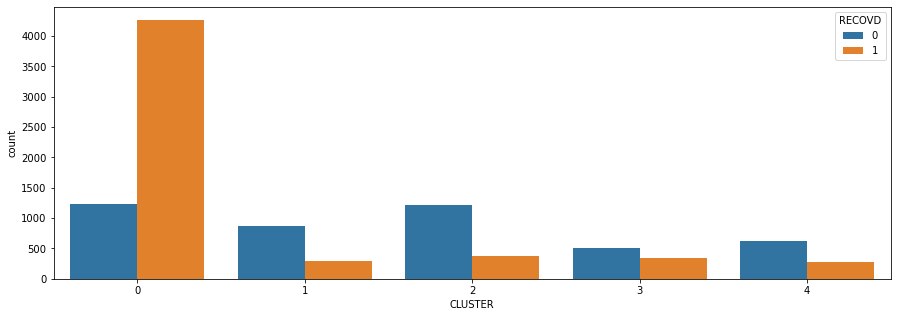

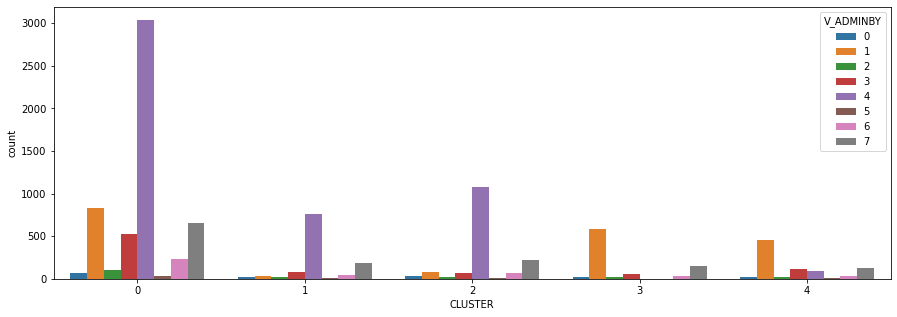

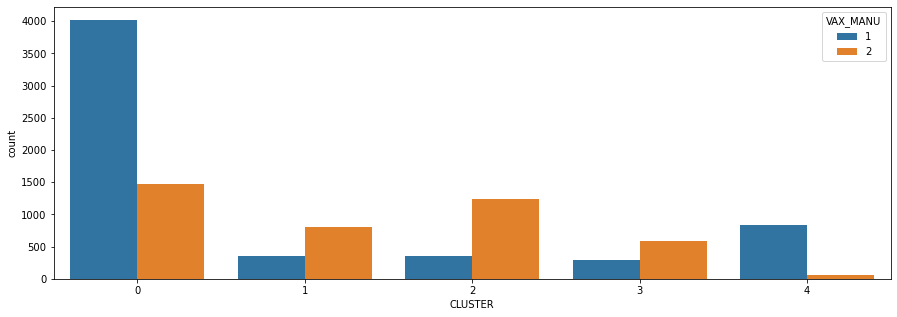

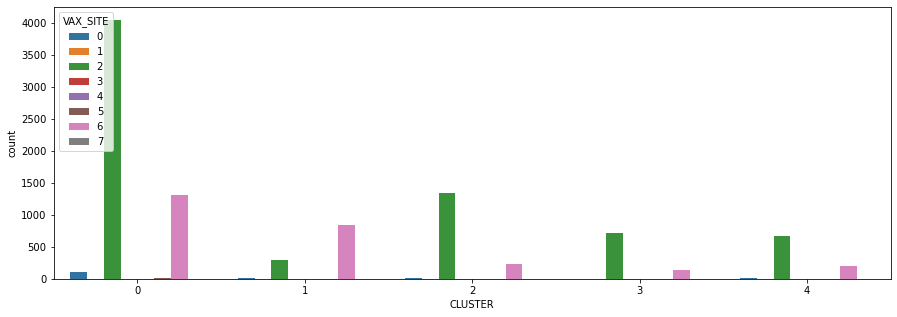

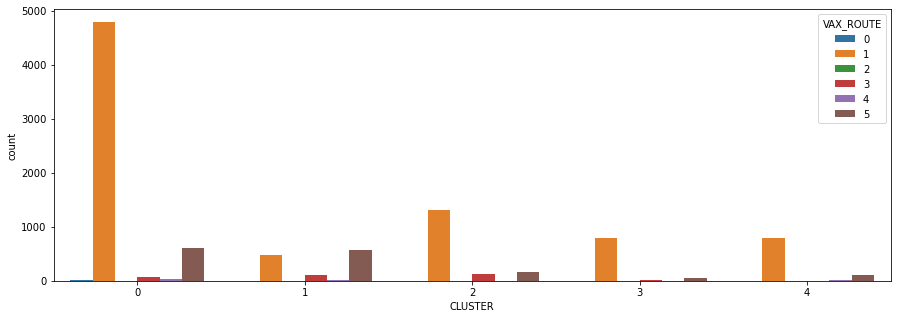

In [33]:
features = [
    'AGE_GRP','SEX','DIED','L_THREAT', 'ER_VISIT',
    'HOSPITAL','DISABLE','BIRTH_DEFECT','RECOVD', 
    'V_ADMINBY','VAX_MANU','VAX_SITE','VAX_ROUTE'
    ]

for i in features:
    plt.subplots(figsize = (15,5))
    sns.countplot(x='CLUSTER',hue=i, data = sample)
    plt.show()

In [34]:
cluster_0 = sample[sample['CLUSTER']==0].value_counts()
cluster_0.to_csv("../results/cluster_0.csv")

print(cluster_0.head(15))

SEX  DIED  L_THREAT  ER_VISIT  HOSPITAL  DISABLE  BIRTH_DEFECT  RECOVD  V_ADMINBY  VAX_MANU  VAX_SITE  VAX_ROUTE  AGE_GRP  CLUSTER
0    0     0         0         0         0        0             0       4          1         2         1          3        0          188
                                                                1       4          2         2         1          3        0          180
                                                                                   1         2         1          3        0          169
                                                                                   2         2         1          4        0          164
                                                                0       4          1         2         1          4        0          152
                                                                1       4          1         2         1          4        0          135
                                         

We see that the patients in cluster 0 are mostly:
- female
- eme eme

In [35]:
cluster_1 = sample[sample['CLUSTER']==1].value_counts()
cluster_1.to_csv("../results/cluster_1.csv")

print(cluster_1.head(15))

SEX  DIED  L_THREAT  ER_VISIT  HOSPITAL  DISABLE  BIRTH_DEFECT  RECOVD  V_ADMINBY  VAX_MANU  VAX_SITE  VAX_ROUTE  AGE_GRP  CLUSTER
0    0     0         0         0         0        0             1       4          2         6         1          4        1          73
                                                                0       4          1         6         1          4        1          65
                                                                                   2         6         1          3        1          51
                                                                                   1         2         5          4        1          45
                                                                                   2         6         1          4        1          39
                                                                                             2         5          3        1          29
                                               

In [36]:
cluster_2 = sample[sample['CLUSTER']==2].value_counts()
cluster_2.to_csv("../results/cluster_2.csv")

print(cluster_2.head(15))

SEX  DIED  L_THREAT  ER_VISIT  HOSPITAL  DISABLE  BIRTH_DEFECT  RECOVD  V_ADMINBY  VAX_MANU  VAX_SITE  VAX_ROUTE  AGE_GRP  CLUSTER
0    0     0         0         0         0        0             0       4          2         2         1          3        2          115
                                                                                                                  4        2          102
                                                                1       4          2         2         1          2        2           99
                                                                0       4          1         2         1          2        2           99
                                                                                   2         2         1          5        2           68
                                                                                                                  2        2           62
                                         

In [37]:
cluster_3 = sample[sample['CLUSTER']==3].value_counts()
cluster_3.to_csv("../results/cluster_3.csv")

print(cluster_3.head(15))

SEX  DIED  L_THREAT  ER_VISIT  HOSPITAL  DISABLE  BIRTH_DEFECT  RECOVD  V_ADMINBY  VAX_MANU  VAX_SITE  VAX_ROUTE  AGE_GRP  CLUSTER
0    0     0         0         0         0        0             0       1          1         2         1          4        3          75
                                                                1       1          2         2         1          4        3          52
                                                                0       7          1         2         1          4        3          47
                                                                1       1          2         2         1          5        3          45
                                                                        7          2         2         1          4        3          44
                                                                0       7          2         2         1          4        3          40
                                               

In [43]:
cluster_4 = sample[sample['CLUSTER']==4].value_counts()
cluster_4.to_csv("../results/cluster_4.csv")

print(cluster_4.head(15))

SEX  DIED  L_THREAT  ER_VISIT  HOSPITAL  DISABLE  BIRTH_DEFECT  RECOVD  V_ADMINBY  VAX_MANU  VAX_SITE  VAX_ROUTE  AGE_GRP  CLUSTER
0    0     0         0         0         0        0             0       1          1         2         1          5        4          57
1    0     0         0         0         0        0             1       1          1         2         1          5        4          41
0    0     0         0         0         0        0             0       7          1         2         1          5        4          40
1    0     0         0         0         0        0             1       1          1         2         1          4        4          36
0    0     0         0         0         0        0             0       3          1         2         1          5        4          30
1    0     0         0         0         0        0             0       1          1         2         1          5        4          28
                                               

In [40]:
cluster_5 = patients[patients['CLUSTER']==5].value_counts()
cluster_5.to_csv("../results/cluster_5.csv")

print(cluster_5.head(15))

KeyError: 'CLUSTER'

In [ ]:
cluster_6 = patients[patients['CLUSTER']==6].value_counts()
cluster_6.to_csv("../results/cluster_6.csv")

print(cluster_6.head(15))

## PART 5: Conclusion